## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [7]:
import os
import keras
import itertools
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.layers import BatchNormalization, Activation
%matplotlib inline

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
from keras.layers import BatchNormalization, Activation
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

# 不同的BATCH_SIZE

In [12]:
def plot_model_score(results):
    color_bar = ["r", "g", "b", "y", "m", "k"] 
    plt.figure(figsize=(10,8))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label='train-'+cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label='valid-'+cond, color=color_bar[i])
    plt.title("Loss")
    plt.legend()
    plt.show()


    plt.figure(figsize=(10,8))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label='train-'+cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label='valid-'+cond, color=color_bar[i])
    plt.title("Accuracy")
    plt.legend()
    plt.show()

In [11]:
## 超參數設定
"""
Set your hyper-parameters
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [20, 160, 256, 512, 1024] 
MOMENTUM = 0.95

In [13]:
results = {}
"""
Write your training loop and record results
"""
for bs in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=bs, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-batch_size-%s" % str(bs)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

Epoch 50/50
50000/50000 [==============================] - 59s 1ms/step - loss: 0.9892 - acc: 0.6465 - val_loss: 1.3596 - val_acc: 0.5354
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
____

50000/50000 [==============================] - 16s 313us/step - loss: 0.2135 - acc: 0.9383 - val_loss: 2.2931 - val_acc: 0.4746
Epoch 47/50
50000/50000 [==============================] - 16s 313us/step - loss: 0.1946 - acc: 0.9458 - val_loss: 2.3075 - val_acc: 0.4729
Epoch 48/50
50000/50000 [==============================] - 16s 314us/step - loss: 0.1911 - acc: 0.9466 - val_loss: 2.4584 - val_acc: 0.4669
Epoch 49/50
50000/50000 [==============================] - 16s 312us/step - loss: 0.1818 - acc: 0.9492 - val_loss: 2.4799 - val_acc: 0.4513
Epoch 50/50
50000/50000 [==============================] - 16s 313us/step - loss: 0.1700 - acc: 0.9543 - val_loss: 2.4432 - val_acc: 0.4704
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)        

50000/50000 [==============================] - 13s 261us/step - loss: 0.6267 - acc: 0.8101 - val_loss: 1.5684 - val_acc: 0.4929
Epoch 43/50
50000/50000 [==============================] - 13s 261us/step - loss: 0.6084 - acc: 0.8167 - val_loss: 1.5879 - val_acc: 0.4913
Epoch 44/50
50000/50000 [==============================] - 13s 261us/step - loss: 0.5917 - acc: 0.8220 - val_loss: 1.6240 - val_acc: 0.4808
Epoch 45/50
50000/50000 [==============================] - 13s 262us/step - loss: 0.5748 - acc: 0.8287 - val_loss: 1.6222 - val_acc: 0.4917
Epoch 46/50
50000/50000 [==============================] - 13s 261us/step - loss: 0.5560 - acc: 0.8367 - val_loss: 1.6363 - val_acc: 0.4871
Epoch 47/50
50000/50000 [==============================] - 13s 261us/step - loss: 0.5407 - acc: 0.8423 - val_loss: 1.6385 - val_acc: 0.4891
Epoch 48/50
50000/50000 [==============================] - 13s 261us/step - loss: 0.5239 - acc: 0.8513 - val_loss: 1.6600 - val_acc: 0.4885
Epoch 49/50
50000/50000 [=======

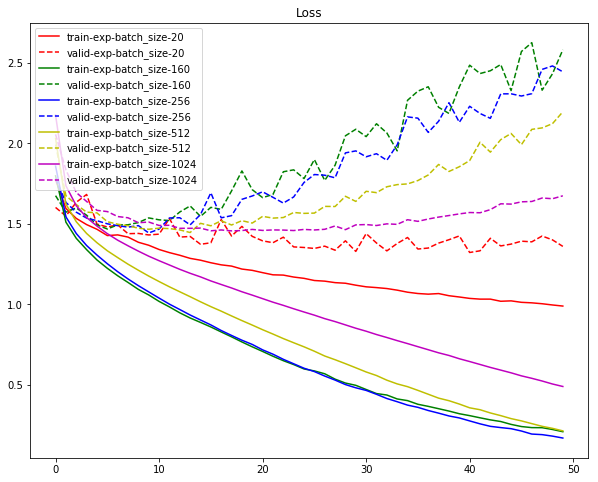

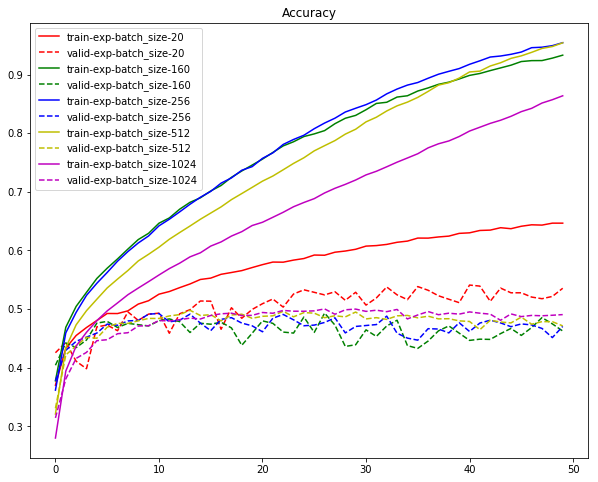

In [14]:
"""
Plot results
"""
plot_model_score(results)

# BN 放在 Activation 之前

In [22]:
from keras.layers import Activation
def build_mlp_BN(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    
    model = Sequential()
    model.add(Dense(units = input_shape[1] ,input_dim = input_shape[1], activation = 'relu',name = 'input'))
    
    for i, n_units in enumerate(num_neurons):
        model.add(Dense(units=n_units,name="hidden_layer"+str(i+1)))  
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
                
    model.add(Dense(units=output_units,activation='softmax',name='output'))

    return model

In [24]:
results = {}
BATCH_SIZE = [128 , 1024] 
for batch_size in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    model = build_mlp_BN(input_shape=x_train.shape)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch_size, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-batch_size-%s" % str(batch_size)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
__________

Epoch 47/50
50000/50000 [==============================] - 105s 2ms/step - loss: 0.0588 - acc: 0.9834 - val_loss: 2.9075 - val_acc: 0.4892
Epoch 48/50
50000/50000 [==============================] - 106s 2ms/step - loss: 0.0564 - acc: 0.9848 - val_loss: 2.8121 - val_acc: 0.4791
Epoch 49/50
50000/50000 [==============================] - 102s 2ms/step - loss: 0.0584 - acc: 0.9833 - val_loss: 2.8198 - val_acc: 0.4896
Epoch 50/50
50000/50000 [==============================] - 100s 2ms/step - loss: 0.0564 - acc: 0.9840 - val_loss: 2.9207 - val_acc: 0.4794
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)        

50000/50000 [==============================] - 65s 1ms/step - loss: 0.1365 - acc: 0.9906 - val_loss: 1.7748 - val_acc: 0.4852
Epoch 44/50
50000/50000 [==============================] - 65s 1ms/step - loss: 0.1265 - acc: 0.9918 - val_loss: 1.7773 - val_acc: 0.4972
Epoch 45/50
50000/50000 [==============================] - 65s 1ms/step - loss: 0.1149 - acc: 0.9935 - val_loss: 1.8053 - val_acc: 0.4945
Epoch 46/50
50000/50000 [==============================] - 65s 1ms/step - loss: 0.1056 - acc: 0.9944 - val_loss: 1.7738 - val_acc: 0.5011
Epoch 47/50
50000/50000 [==============================] - 65s 1ms/step - loss: 0.0983 - acc: 0.9953 - val_loss: 1.7963 - val_acc: 0.4966
Epoch 48/50
50000/50000 [==============================] - 65s 1ms/step - loss: 0.0896 - acc: 0.9961 - val_loss: 1.8619 - val_acc: 0.4934
Epoch 49/50
50000/50000 [==============================] - 65s 1ms/step - loss: 0.0824 - acc: 0.9970 - val_loss: 1.8233 - val_acc: 0.4943
Epoch 50/50
50000/50000 [=====================

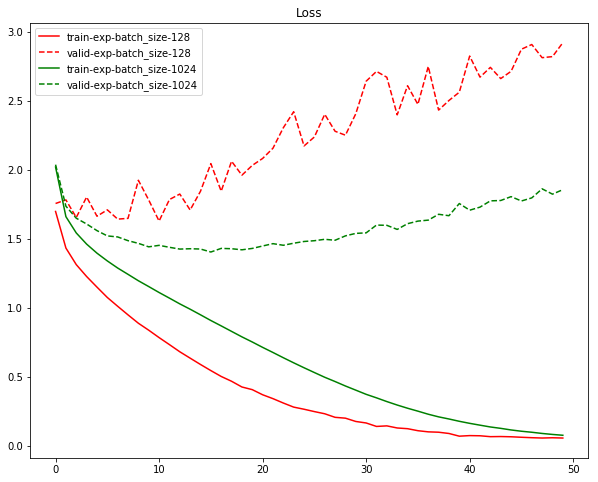

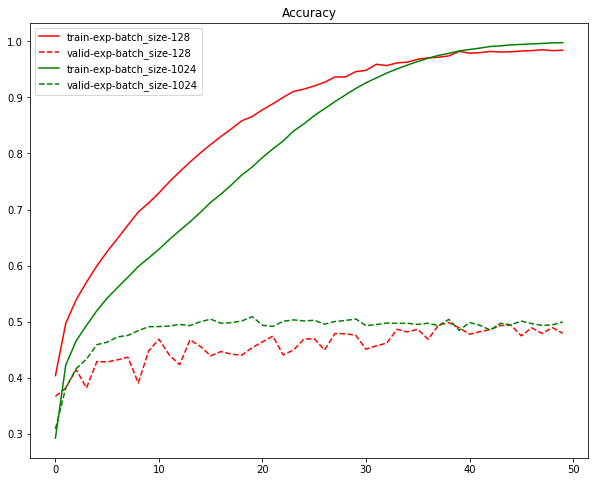

In [25]:
plot_model_score(results)

# BN 放在 Input Layer 後

In [5]:
def build_mlp_afterIn(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    
    model = Sequential()
    model.add(Dense(units = input_shape[1] ,input_dim = input_shape[1], activation = 'relu',name = 'input'))
    model.add(BatchNormalization())
  
    for i, n_units in enumerate(num_neurons):
        model.add(Dense(units=n_units,name="hidden_layer"+str(i+1)))  
        model.add(Activation('relu'))
        
                
    model.add(Dense(units=output_units,activation='softmax',name='output'))

    return model

In [9]:
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [128, 1024] 
MOMENTUM = 0.95

In [10]:
results = {}
BATCH_SIZE = [128 , 1024] 
for batch_size in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    model = build_mlp_afterIn(input_shape=x_train.shape)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch_size, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-batch_size-%s" % str(batch_size)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
__________

50000/50000 [==============================] - 103s 2ms/step - loss: 0.2714 - acc: 0.9065 - val_loss: 2.5653 - val_acc: 0.4747
Epoch 49/50
50000/50000 [==============================] - 102s 2ms/step - loss: 0.2774 - acc: 0.9044 - val_loss: 2.4637 - val_acc: 0.4907
Epoch 50/50
50000/50000 [==============================] - 103s 2ms/step - loss: 0.2423 - acc: 0.9164 - val_loss: 2.5077 - val_acc: 0.4928
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 3072)              9440256   
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_

50000/50000 [==============================] - 78s 2ms/step - loss: 0.0919 - acc: 0.9907 - val_loss: 2.0142 - val_acc: 0.5262
Epoch 47/50
50000/50000 [==============================] - 77s 2ms/step - loss: 0.0833 - acc: 0.9922 - val_loss: 2.0367 - val_acc: 0.5265
Epoch 48/50
50000/50000 [==============================] - 76s 2ms/step - loss: 0.0754 - acc: 0.9932 - val_loss: 2.0561 - val_acc: 0.5294
Epoch 49/50
50000/50000 [==============================] - 76s 2ms/step - loss: 0.0692 - acc: 0.9947 - val_loss: 2.0928 - val_acc: 0.5277
Epoch 50/50
50000/50000 [==============================] - 76s 2ms/step - loss: 0.0633 - acc: 0.9953 - val_loss: 2.0990 - val_acc: 0.5313


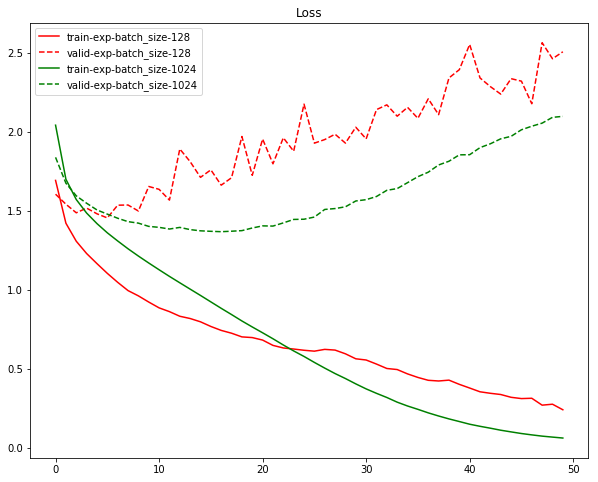

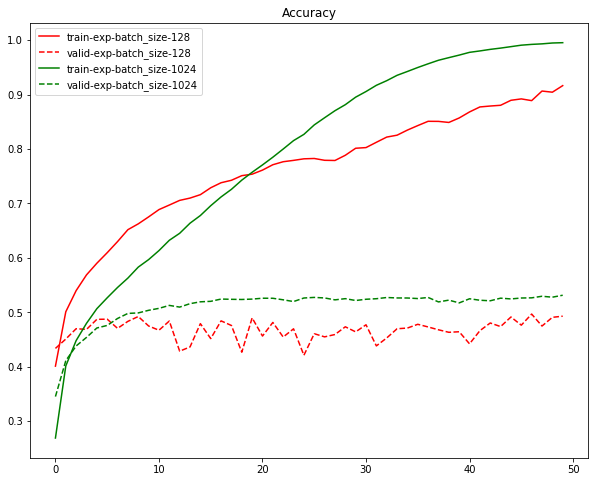

In [13]:
plot_model_score(results)